[INFO] loading YOLO from disk...
[INFO] YOLO took 1.385349 seconds
[INFO] predect result is:  bird: 0.9994


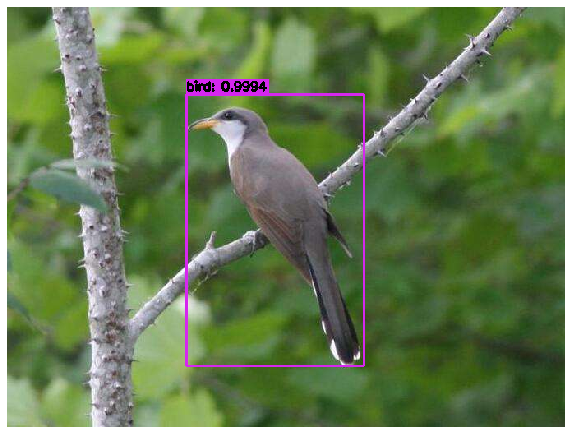

[INFO] loading YOLO from disk...
[INFO] YOLO took 1.474056 seconds
[INFO] predect result is:  dog: 0.9847


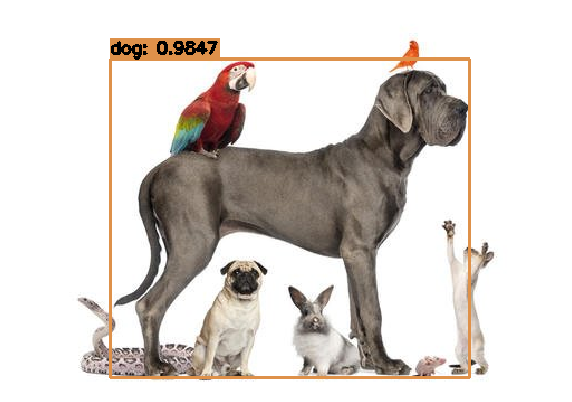

[INFO] predect result is:  cat: 0.6775


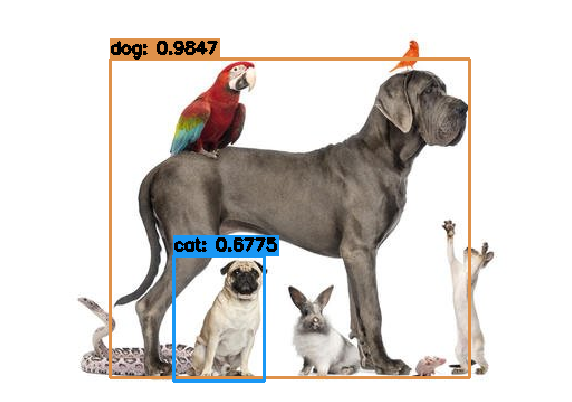

[INFO] predect result is:  bird: 0.5771


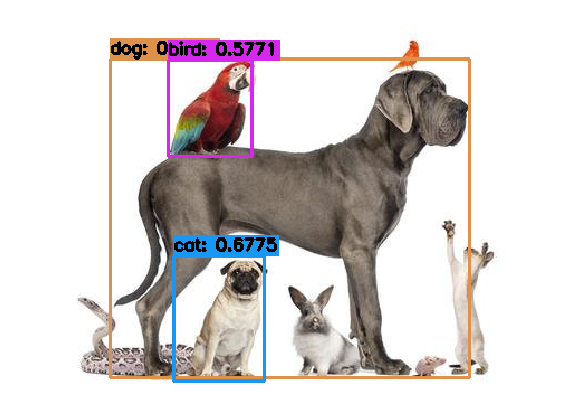

In [21]:
import numpy as np
import cv2 as cv
import os
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#参数
yolo_dir = 'D:/myworkspace/dataset/yolov3/'  # YOLO文件路径
CONFIDENCE = 0.5  # 过滤弱检测的最小概率
THRESHOLD = 0.4  # 非最大值抑制阈值

def yolov3(imgPath,yolo_dir,CONFIDENCE,THRESHOLD):
    weightsPath = os.path.join(yolo_dir, 'yolov3.weights')  # 权重文件
    configPath = os.path.join(yolo_dir, 'yolov3.cfg')  # 配置文件
    labelsPath = os.path.join(yolo_dir, 'coco.names')  # label名称
    # 加载网络、配置权重
    net = cv.dnn.readNetFromDarknet(configPath, weightsPath)  ## 利用下载的文件
    print("[INFO] loading YOLO from disk...") ## 可以打印下信息

    # 加载图片、转为blob格式、送入网络输入层
    img = cv.imread(imgPath)
    blobImg = cv.dnn.blobFromImage(img, 1.0/255.0, (416, 416), None, True, False)  ## net需要的输入是blob格式的，用blobFromImage这个函数来转格式
    net.setInput(blobImg)  ## 调用setInput函数将图片送入输入层

    # 获取网络输出层信息（所有输出层的名字），设定并前向传播
    outInfo = net.getUnconnectedOutLayersNames()  ## 前面的yolov3架构也讲了，yolo在每个scale都有输出，outInfo是每个scale的名字信息，供net.forward使用
    start = time.time()
    layerOutputs = net.forward(outInfo)  # 得到各个输出层的、各个检测框等信息，是二维结构。
    end = time.time()
    print("[INFO] YOLO took {:.6f} seconds".format(end - start)) ## 可以打印下信息

    # 拿到图片尺寸
    (H, W) = img.shape[:2]
    # 过滤layerOutputs
    # layerOutputs的第1维的元素内容: [center_x, center_y, width, height, objectness, N-class score data]
    # 过滤后的结果放入：
    boxes = [] # 所有边界框（各层结果放一起）
    confidences = [] # 所有置信度
    classIDs = [] # 所有分类ID

    # # 1）过滤掉置信度低的框框
    for out in layerOutputs:  # 各个输出层
        for detection in out:  # 各个框框
            # 拿到置信度
            scores = detection[5:]  # 各个类别的置信度
            classID = np.argmax(scores)  # 最高置信度的id即为分类id
            confidence = scores[classID]  # 拿到置信度

            # 根据置信度筛查
            if confidence > CONFIDENCE:
                box = detection[0:4] * np.array([W, H, W, H])  # 将边界框放会图片尺寸
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # # 2）应用非最大值抑制(non-maxima suppression，nms)进一步筛掉
    idxs = cv.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD) # boxes中，保留的box的索引index存入idxs

    # 得到labels列表
    with open(labelsPath, 'rt') as f:
        labels = f.read().rstrip('\n').split('\n')

    # 应用检测结果
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")  # 框框显示颜色，每一类有不同的颜色，每种颜色都是由RGB三个值组成的，所以size为(len(labels), 3)
    if len(idxs) > 0:
        for i in idxs.flatten(): # indxs是二维的，第0维是输出层，所以这里把它展平成1维
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)  # 线条粗细为2px
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            print("[INFO] predect result is: ",text)
            (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(img, (x, y-text_h-baseline), (x + text_w, y), color, -1)
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)  # cv.FONT_HERSHEY_SIMPLEX字体风格、0.5字体大小、粗细2px
            # cv.imshow('detected image', img)
            # cv.waitKey(0)
            plt.figure(figsize=[10, 10])
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.show()
            

imgPath = os.path.join(yolo_dir, 'test.jpg')  # 测试图像
yolov3(imgPath,yolo_dir,CONFIDENCE,THRESHOLD)


imgPath = os.path.join(yolo_dir, 'test2.jpg')  # 测试图像
yolov3(imgPath,yolo_dir,CONFIDENCE,THRESHOLD)



In [7]:
import numpy as np
import cv2 as cv
import os
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#参数
yolo_dir = 'D:/myworkspace/dataset/yolov3/'  # YOLO文件路径
CONFIDENCE = 0.5  # 过滤弱检测的最小概率
THRESHOLD = 0.4  # 非最大值抑制阈值

def yolov3_vedio(img,yolo_dir,CONFIDENCE,THRESHOLD):
    weightsPath = os.path.join(yolo_dir, 'yolov3.weights')  # 权重文件
    configPath = os.path.join(yolo_dir, 'yolov3.cfg')  # 配置文件
    labelsPath = os.path.join(yolo_dir, 'coco.names')  # label名称
    # 加载网络、配置权重
    net = cv.dnn.readNetFromDarknet(configPath, weightsPath)  ## 利用下载的文件
    print("[INFO] loading YOLO from disk...") ## 可以打印下信息

    blobImg = cv.dnn.blobFromImage(img, 1.0/255.0, (416, 416), None, True, False)  ## net需要的输入是blob格式的，用blobFromImage这个函数来转格式
    net.setInput(blobImg)  ## 调用setInput函数将图片送入输入层

    # 获取网络输出层信息（所有输出层的名字），设定并前向传播
    outInfo = net.getUnconnectedOutLayersNames()  ## 前面的yolov3架构也讲了，yolo在每个scale都有输出，outInfo是每个scale的名字信息，供net.forward使用
    start = time.time()
    layerOutputs = net.forward(outInfo)  # 得到各个输出层的、各个检测框等信息，是二维结构。
    end = time.time()
    print("[INFO] YOLO took {:.6f} seconds".format(end - start)) ## 可以打印下信息

    # 拿到图片尺寸
    (H, W) = img.shape[:2]
    # 过滤layerOutputs
    # layerOutputs的第1维的元素内容: [center_x, center_y, width, height, objectness, N-class score data]
    # 过滤后的结果放入：
    boxes = [] # 所有边界框（各层结果放一起）
    confidences = [] # 所有置信度
    classIDs = [] # 所有分类ID

    # # 1）过滤掉置信度低的框框
    for out in layerOutputs:  # 各个输出层
        for detection in out:  # 各个框框
            # 拿到置信度
            scores = detection[5:]  # 各个类别的置信度
            classID = np.argmax(scores)  # 最高置信度的id即为分类id
            confidence = scores[classID]  # 拿到置信度

            # 根据置信度筛查
            if confidence > CONFIDENCE:
                box = detection[0:4] * np.array([W, H, W, H])  # 将边界框放会图片尺寸
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # # 2）应用非最大值抑制(non-maxima suppression，nms)进一步筛掉
    idxs = cv.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD) # boxes中，保留的box的索引index存入idxs

    # 得到labels列表
    with open(labelsPath, 'rt') as f:
        labels = f.read().rstrip('\n').split('\n')

    # 应用检测结果
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")  # 框框显示颜色，每一类有不同的颜色，每种颜色都是由RGB三个值组成的，所以size为(len(labels), 3)
    if len(idxs) > 0:
        for i in idxs.flatten(): # indxs是二维的，第0维是输出层，所以这里把它展平成1维
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)  # 线条粗细为2px
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            print("[INFO] predect result is: ",text)
            (text_w, text_h), baseline = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv.rectangle(img, (x, y-text_h-baseline), (x + text_w, y), color, -1)
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)  # cv.FONT_HERSHEY_SIMPLEX字体风格、0.5字体大小、粗细2px
        
    return img

cap = cv.VideoCapture(0)

while(True):
    ret, frame = cap.read()                        #读取帧
    yolov3_vedio(frame,yolo_dir,CONFIDENCE,THRESHOLD)
    
    cv.imshow('frame',frame)
    
    if cv.waitKey(1) & 0xFF == ord('q'):          #按‘q’退出
        break

#释放资源并关闭窗口
cap.release()
cv.destroyAllWindows()



[INFO] loading YOLO from disk...
[INFO] YOLO took 0.821798 seconds
[INFO] predect result is:  person: 0.7263
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.755977 seconds
[INFO] predect result is:  person: 0.8187
[INFO] predect result is:  remote: 0.5726
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.740022 seconds
[INFO] predect result is:  person: 0.8818
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.839330 seconds
[INFO] predect result is:  person: 0.6618
[INFO] predect result is:  remote: 0.6417
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.755868 seconds
[INFO] predect result is:  person: 0.8244
[INFO] predect result is:  remote: 0.7099
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.822718 seconds
[INFO] predect result is:  person: 0.7683
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.813823 seconds
[INFO] predect result is:  person: 0.7381
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.871791 seconds
[INFO] predect result is:  person: 0.8483
[I

[INFO] loading YOLO from disk...
[INFO] YOLO took 0.735000 seconds
[INFO] predect result is:  person: 0.9925
[INFO] predect result is:  person: 0.5361
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.713093 seconds
[INFO] predect result is:  person: 0.9985
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.696055 seconds
[INFO] predect result is:  person: 0.9810
[INFO] predect result is:  person: 0.5457
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.734033 seconds
[INFO] predect result is:  person: 0.9815
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.723041 seconds
[INFO] predect result is:  person: 0.9909
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.716717 seconds
[INFO] predect result is:  person: 0.9552
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.720039 seconds
[INFO] predect result is:  person: 0.9497
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.705041 seconds
[INFO] predect result is:  person: 0.9626
[INFO] loading YOLO from disk...
[INFO] YOLO

[INFO] loading YOLO from disk...
[INFO] YOLO took 0.726060 seconds
[INFO] predect result is:  person: 0.9352
[INFO] predect result is:  cell phone: 0.8327
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.710526 seconds
[INFO] predect result is:  person: 0.8185
[INFO] predect result is:  remote: 0.6258
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.698003 seconds
[INFO] predect result is:  person: 0.8117
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.702088 seconds
[INFO] predect result is:  person: 0.8569
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.691366 seconds
[INFO] predect result is:  person: 0.8330
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.716999 seconds
[INFO] predect result is:  person: 0.8144
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.694837 seconds
[INFO] predect result is:  cell phone: 0.9224
[INFO] predect result is:  person: 0.8876
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.685134 seconds
[INFO] predect result is:  cell phon